# Setting up Spark

Start a pySpark session including Diana-Hep spark-root and histogrammar APIs

In [1]:
import pyspark.sql
session = pyspark.sql.SparkSession.builder \
    .master('spark://10.64.22.198:7077') \
    .appName('DemoWithML') \
    .config('spark.jars.packages','org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
    .config('spark.driver.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.executor.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.executor.memory','2g') \
    .config('spark.executor.cores','2') \
    .config('spark.cores.max','9') \
    .getOrCreate()
    
sqlContext = session

print 'SparkSQL sesssion created'

SparkSQL sesssion created


# Loading root files stored remotely on EOS via xrootd

Loading root files (NanoAOD CMS format) from CERN public EOS area via xrootd.
Trees are read using the spark-root

In [2]:
from pyspark.sql.functions import lit
from samples import *

DFList = [] 

for s in samples:
    print 'Loading {0} sample from EOS file'.format(s) 
    dsPath = "root://eospublic.cern.ch//eos/opstest/cmspd-bigdata/"+samples[s]['filename']    
    tempDF = sqlContext.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath)\
                .withColumn("sample", lit(s))                
    DFList.append(tempDF)

Loading TT sample from EOS file
Loading WW sample from EOS file
Loading SingleMuon sample from EOS file
Loading ZZ sample from EOS file
Loading DYJetsToLL sample from EOS file
Loading WZ sample from EOS file


# Access DataFrame content

Get list of columns in the DataFrame ("branches" of the equivalent ROOT TTree).

In [3]:
DFList[0].printSchema()

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: integer (nullable = true)
 |-- event: long (nullable = true)
 |-- CaloMET_phi: float (nullable = true)
 |-- CaloMET_pt: float (nullable = true)
 |-- CaloMET_sumEt: float (nullable = true)
 |-- nElectron: integer (nullable = true)
 |-- Electron_deltaEtaSC: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03EcalRecHitSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03HcalDepth1TowerSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03TkSumPt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxy: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr_ugo: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_d

# Data reduction

Subsets of interesting attributes can be selected via 'select' operations on the DataFrames (equivalent to "pruning" steps in ROOT-based frameworks).

All datasets can be joint into a single DataFrame (e.g. collecting data from various samples).

In [4]:
columns = [
    ### MUON
    'Muon_pt',
    'Muon_eta',
    'Muon_phi',
    'Muon_mass',
    'Muon_charge',
    'Muon_mediumId',
    'Muon_softId',
    'Muon_tightId',
    'nMuon',
    ### SAMPLE
    'sample',
    ### Jet
    'Jet_pt',
]

# Select columns from dataframe
DF = DFList[0].select(columns)
DF.printSchema()

# Merge all dataset into a single dataframe
for df_ in DFList[1:]:
    DF = DF.union(df_.select(columns))

print 'Partitions: {}'.format(DF.rdd.getNumPartitions())

root
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_mediumId: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_softId: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_tightId: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- nMuon: integer (nullable = true)
 |-- sample: string (nullable = false)
 |-- Jet_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)

Partitions: 6


# Data selection

Selection of events based on features is obtained via a 'filter' operation.

Number of entries is obtained by 'count'.

In [5]:
print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()

total number of events in the DataFrame  =  2662199
events in the DataFrame with "nMuon > 0" =  1137837


# Caching - 1

Dataframes can be cached into memory, shared across the Spark cluster nodes, for a faster access.

Caching takes some time...

In [6]:
DF = DF.cache()

# Caching - 2

... but ensures fast data-handling operations afterwards.

In [7]:
print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()

total number of events in the DataFrame  =  2662199
events in the DataFrame with "nMuon > 0" =  1137837


# Data inspection


Events can be inspected with 'show' (as in TTree.Show() ), also concatenating 'select' and 'filter'.

In [8]:
DF.filter(DF['sample'] == 'DYJetsToLL')\
  .select('sample','nMuon','Muon_pt','Muon_eta','Muon_phi','Muon_charge')\
  .show(5)

+----------+-----+-----------+------------+------------+-----------+
|    sample|nMuon|    Muon_pt|    Muon_eta|    Muon_phi|Muon_charge|
+----------+-----+-----------+------------+------------+-----------+
|DYJetsToLL|    1| [34.75507]|[-1.3212891]|[-1.0375977]|        [1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    1|[3.3921983]|[-1.5285645]|[-0.2514038]|       [-1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    0|         []|          []|          []|         []|
+----------+-----+-----------+------------+------------+-----------+
only showing top 5 rows



# Create derivate quantities and structures - 1

User defined functions can be used for transformations evalueted row by row to compute derived quantity, such as invaraint mass of two physics objects involving multiple column.
The return value is added as a new column in the output DataFrame.

Dimuon candidate structure is created as an example.

In [9]:
from math import *
from pyspark.sql.types import *

dimuonSchema = StructType([
    StructField("pass", BooleanType(), False),   # True if filled / False if default(empty) 
    #
    StructField("mass", FloatType(), False),     # Dimuon mass
    StructField("pt", FloatType(), False),       # Dimuon pt
    StructField("eta", FloatType(), False),      # Dimuon eta
    StructField("phi", FloatType(), False),      # Dimuon phi
    StructField("dPhi", FloatType(), False),     # DeltaPhi(mu1,mu2)
    StructField("dR", FloatType(), False),       # DeltaR(mu1,mu2)
    StructField("dEta", FloatType(), False),     # DeltaEta(mu1,mu2)
    #
    StructField("mu1_pt", FloatType(), False),   # leading mu pT 
    StructField("mu2_pt", FloatType(), False),   # sub-leading mu pT 
    StructField("mu1_eta", FloatType(), False),  # leading mu eta
    StructField("mu2_eta", FloatType(), False),  # sub-leading mu eta
    StructField("mu1_phi", FloatType(), False),  # leading mu phi
    StructField("mu2_phi", FloatType(), False),  # sub-leading mu phi
])

def binaryWeight(pt):
    for idx in range(len(pt)):
        if pt[idx]>50:
            return 0.
        else:
            return 1.

def deltaPhi(phi1,phi2):
    ## Catch if being called with two objects
    if type(phi1) != float and type(phi1) != int:
        phi1 = phi1.phi
    if type(phi2) != float and type(phi2) != int:
        phi2 = phi2.phi
    ## Otherwise
    dphi = (phi1-phi2)
    while dphi >  pi: dphi -= 2*pi
    while dphi < -pi: dphi += 2*pi
    return dphi

def deltaR(eta1,phi1,eta2=None,phi2=None):
    ## catch if called with objects
    if eta2 == None:
        return deltaR(eta1.eta,eta1.phi,phi1.eta,phi1.phi)
    ## otherwise
    return hypot(eta1-eta2, deltaPhi(phi1,phi2))

def invMass(pt1, pt2, eta1, eta2, phi1, phi2, mass1, mass2):
    #
    theta1 = 2.0*atan(exp(-eta1))
    px1    = pt1 * cos(phi1)
    py1    = pt1 * sin(phi1)
    pz1    = pt1 / tan(theta1)
    E1     = sqrt(px1**2 + py1**2 + pz1**2 + mass1**2)

    theta2 = 2.0*atan(exp(-eta2))
    px2    = pt2 * cos(phi2)
    py2    = pt2 * sin(phi2)
    pz2    = pt2 / tan(theta2)
    E2     = sqrt(px2**2 + py2**2 + pz2**2 + mass2**2)

    themass  = sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
    thept    = sqrt((px1 + px2)**2 + (py1 + py2)**2)
    thetheta = atan( thept / (pz1 + pz2) )        
    theeta   = 0.5*log( (sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)+(pz1 + pz2))/(sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)-(pz1 + pz2)) )
    thephi   = asin((py1 + py2)/thept)

    delPhi = deltaPhi(phi1,phi2)
    delR   = deltaR(eta1,phi1,eta2,phi2)
    delEta = eta1-eta2

    return (themass, thept, theeta, thephi, delPhi, delR, delEta)

def dimuonCandidate(pt, eta, phi, mass, charge, mediumid):
    # default class implementation   
    default_ = (False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    
    """
    Z->mm candidate from arbitrary muon selection:
      N(mu) >= 2
      pT > 30, 10
      abs(eta) < 2.4, 2.4
      mediumId muon
      opposite charge
    """
    
    if len(pt) < 2:
        return default_
    
    #Identify muon candidate
    leadingIdx = None
    trailingIdx = None
 
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                trailingIdx = idx
        else:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                return default_

    if leadingIdx != None and trailingIdx != None and charge[leadingIdx] != charge[trailingIdx]:            
        # Candidate found
        dimuon_   = (True,) + \
                    invMass(pt[leadingIdx], pt[trailingIdx],
                            eta[leadingIdx], eta[trailingIdx],
                            phi[leadingIdx], phi[trailingIdx],
                            mass[leadingIdx], mass[trailingIdx]) + \
                    (pt[leadingIdx], pt[trailingIdx],
                     eta[leadingIdx], eta[trailingIdx],
                     phi[leadingIdx], phi[trailingIdx])
                
        return dimuon_
    else:
        return default_    

# Create derivate quantities and structures - 2

And a generic function filling the candidate structure can be defined.

# Create derivate quantities and structures - 3

Finally, a dimuon candidate structure can be appended to the DataFrame as an additional column

In [10]:
from pyspark.sql.functions import udf
dimuonUDF = udf(dimuonCandidate, dimuonSchema)
biweightUDF = udf(binaryWeight, FloatType())

DF = DF.withColumn('Dimuon', dimuonUDF ("Muon_pt",
                                        "Muon_eta",
                                        "Muon_phi",
                                        "Muon_mass",
                                        "Muon_charge",
                                        "Muon_mediumId")
                  )

DF = DF.withColumn('pseudoweight', biweightUDF("Muon_pt"))

DF.where('Dimuon.pass == True').select('Dimuon').show(3)
DF.where('Dimuon.pass == True').select('pseudoweight').show(3)


+--------------------+
|              Dimuon|
+--------------------+
|[true,144.83916,1...|
|[true,71.81045,10...|
|[true,77.16723,58...|
+--------------------+
only showing top 3 rows

+------------+
|pseudoweight|
+------------+
|         0.0|
|         0.0|
|         0.0|
+------------+
only showing top 3 rows



In [11]:
DF.where('Dimuon.pass == True').where('Muon_pt[0] > 40').select('pseudoweight','Muon_pt').show(20)

+------------+--------------------+
|pseudoweight|             Muon_pt|
+------------+--------------------+
|         0.0|[135.60971, 49.35...|
|         0.0|[86.59694, 30.364...|
|         0.0|[69.71808, 11.31618]|
|         0.0|[94.496475, 35.00...|
|         0.0|[88.46852, 29.086...|
|         0.0|[64.19878, 14.269...|
|         1.0|[46.05904, 10.937...|
|         0.0|[52.871307, 45.92...|
|         0.0|[58.367897, 11.40...|
|         0.0|[73.15759, 34.10927]|
|         1.0|[40.73455, 28.183...|
|         0.0|[77.04779, 17.418...|
|         0.0|[139.45297, 38.15...|
|         0.0|[55.67394, 18.035...|
|         1.0|[41.773323, 23.36...|
|         0.0|[63.511578, 20.69...|
|         0.0|[64.202545, 49.66...|
|         1.0|[44.118664, 18.90...|
|         0.0|[136.13123, 49.81...|
|         0.0|[51.019943, 15.04...|
+------------+--------------------+
only showing top 20 rows



# Get statistics info about the data

Exploit pySparkSql functions to get statistical insights on the DataFrame

In [12]:
from pyspark.sql.functions import *

print 'Number of events, pre-selection level'

DF.groupBy("sample").count().show()

print 'Number of events, Dimuon invariant mass in [70-110] GeV'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy("sample").count().show()

print 'Mean of Dimuon mass, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy('sample').mean('Dimuon.mass').show()

print 'Description of Dimuon mass features for SingleMuon dataset only, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) & (DF["sample"] == "SingleMuon") ).describe('Dimuon.mass').show()


Number of events, pre-selection level
+----------+------+
|    sample| count|
+----------+------+
|        ZZ|480144|
|        WW|348954|
|DYJetsToLL|549790|
|SingleMuon|477186|
|        WZ|424048|
|        TT|382077|
+----------+------+

Number of events, Dimuon invariant mass in [70-110] GeV
+----------+-----+
|    sample|count|
+----------+-----+
|        ZZ|16201|
|        WW|  710|
|DYJetsToLL|67831|
|SingleMuon|13934|
|        WZ| 7209|
|        TT| 1760|
+----------+-----+

Mean of Dimuon mass, evaluated in [70-110] GeV range
+----------+--------------------------+
|    sample|avg(Dimuon.mass AS `mass`)|
+----------+--------------------------+
|        ZZ|         90.39599790585481|
|        WW|         88.08453911794743|
|DYJetsToLL|         90.19341036229169|
|SingleMuon|         89.91447557800039|
|        WZ|         90.19251177561962|
|        TT|         86.54928711977873|
+----------+--------------------------+

Description of Dimuon mass features for SingleMuon dataset o

# Plotting the Zpeak mass

In [13]:
# Load libraries, and append histogrammar functionalities to dataframe
import matplotlib.pyplot as plt
%matplotlib inline
import histogrammar as hg
import histogrammar.sparksql
import numpy as np

DF = DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) )

hg.sparksql.addMethods(DF)

plots = hg.UntypedLabel(
    # 1d histograms
    LeadPtW      = hg.Bin(50, 30, 180,   DF['Dimuon.mu1_pt'], hg.Sum(DF['pseudoweight'])),
    LeadPt       = hg.Bin(50, 30, 180,   DF['Dimuon.mu1_pt']),
    LeadPtEta    = hg.Bin(48, -2.4, 2.4, DF['Dimuon.mu1_eta']),
    SubLeadPt    = hg.Bin(100, 0, 200,   DF['Dimuon.mu2_pt']),
    SubLeadPtEta = hg.Bin(48, -2.4, 2.4, DF['Dimuon.mu2_eta']),
    InvMass      = hg.Bin(80, 70, 110,   DF['Dimuon.mass']),
    DeltaR       = hg.Bin(50, 0, 5,      DF['Dimuon.dPhi']),
    DeltaPhi     = hg.Bin(64, -3.2, 3.2, DF['Dimuon.dR']),
)

# Make a set of histograms, categorized per-sample
bulkHisto = hg.Categorize(quantity = DF['sample'], value = plots)

# Fill from spark
bulkHisto.fillsparksql(df=DF)


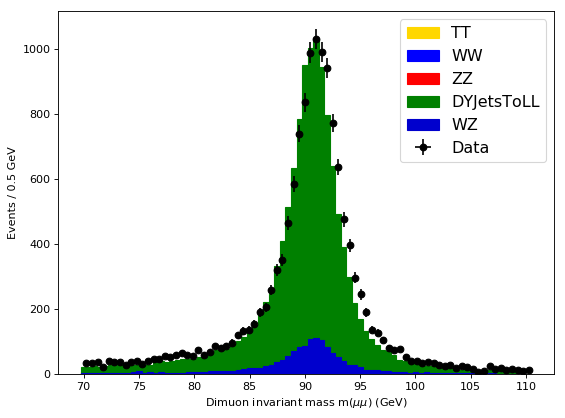

In [14]:
VARIABLE = 'InvMass'

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

aHisto   = bulkHisto("SingleMuon")(VARIABLE)
nBins    = len(aHisto.values)
edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
width    = (aHisto.high - aHisto.low) / nBins

plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.toJson()['data']*0.19 for x in bulkHisto(k)(VARIABLE).values]
    plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True)
    
xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
ydata   = [x.toJson()['data'] for x in bulkHisto('SingleMuon')(VARIABLE).values]
yerror  = [x**0.5 for x in ydata]

plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')

plt.xlabel('Dimuon invariant mass m($\mu\mu$) (GeV)')
plt.ylabel('Events / 0.5 GeV')
plt.legend(loc='upper right', fontsize='x-large', )


# Plotting with pseudoweight

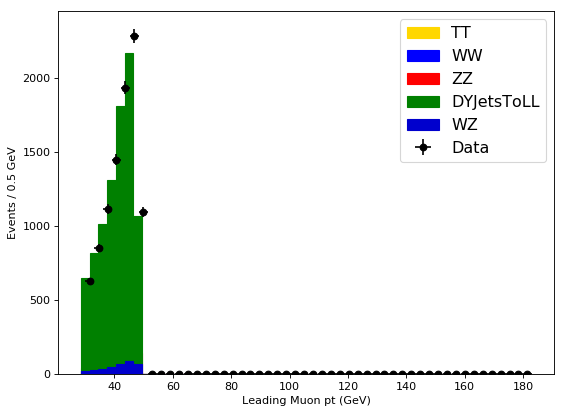

In [15]:
VARIABLE = 'LeadPtW'

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

aHisto   = bulkHisto("SingleMuon")(VARIABLE)
nBins    = len(aHisto.values)
edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
width    = (aHisto.high - aHisto.low) / nBins

plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.sum*0.19 for x in bulkHisto(k)(VARIABLE).values]
    plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True)
    
xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
ydata   = [x.sum for x in bulkHisto('SingleMuon')(VARIABLE).values]
yerror  = [x**0.5 for x in ydata]

plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')

plt.xlabel('Leading Muon pt (GeV)')
plt.ylabel('Events / 0.5 GeV')
plt.legend(loc='upper right', fontsize='x-large', )


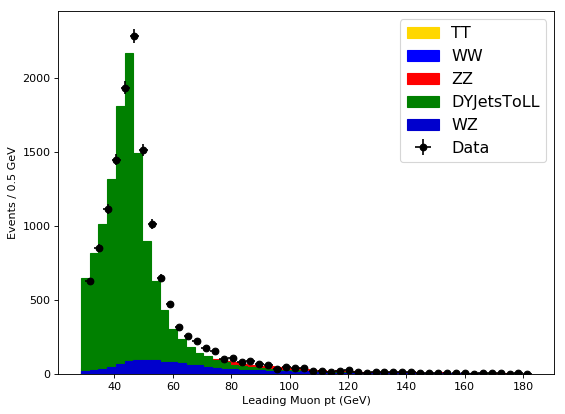

In [16]:
VARIABLE = 'LeadPt'

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

aHisto   = bulkHisto("SingleMuon")(VARIABLE)
nBins    = len(aHisto.values)
edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
width    = (aHisto.high - aHisto.low) / nBins

plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.toJson()['data']*0.19 for x in bulkHisto(k)(VARIABLE).values]
    plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True)
    
xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
ydata   = [x.toJson()['data'] for x in bulkHisto('SingleMuon')(VARIABLE).values]
yerror  = [x**0.5 for x in ydata]

plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')

plt.xlabel('Leading Muon pt (GeV)')
plt.ylabel('Events / 0.5 GeV')
plt.legend(loc='upper right', fontsize='x-large', )


# ML Learning Extension

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import rand
#from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.mllib.linalg import Vectors, VectorUDT
vectorizer = udf(lambda x: Vectors.dense(x), VectorUDT())

DDF = DF.filter(DF['nMuon']==2)
dataset1 = DDF.filter(DF['sample']=='DYJetsToLL').select('Muon_Pt')
dataset1 = dataset1.withColumn('label', lit('DYJetsToLL'))
dataset2 = DDF.filter(DF['sample']=='WZ').select('Muon_Pt')
dataset2 = dataset2.withColumn('label', lit('WZ'))
dataset = dataset1.union(dataset2)
dataset = dataset.select( vectorizer(dataset["Muon_Pt"]).alias("features"), dataset['label'])
dataset = dataset.orderBy(rand())

In [18]:
dataset.show(30)

+--------------------+----------+
|            features|     label|
+--------------------+----------+
|[31.3118038177490...|DYJetsToLL|
|[45.6242408752441...|DYJetsToLL|
|[43.1918983459472...|DYJetsToLL|
|[45.7739410400390...|DYJetsToLL|
|[45.6629867553710...|DYJetsToLL|
|[63.0259704589843...|DYJetsToLL|
|[43.3254776000976...|DYJetsToLL|
|[95.6891555786132...|        WZ|
|[79.9691085815429...|DYJetsToLL|
|[48.123779296875,...|DYJetsToLL|
|[45.5417060852050...|DYJetsToLL|
|[141.762512207031...|        WZ|
|[35.8414878845214...|DYJetsToLL|
|[42.3892517089843...|DYJetsToLL|
|[40.0167198181152...|DYJetsToLL|
|[94.1939773559570...|DYJetsToLL|
|[34.7664566040039...|DYJetsToLL|
|[44.6018447875976...|DYJetsToLL|
|[48.6763381958007...|DYJetsToLL|
|[66.5032424926757...|DYJetsToLL|
|[36.1186676025390...|DYJetsToLL|
|[51.1560554504394...|DYJetsToLL|
|[35.1636276245117...|DYJetsToLL|
|[48.4958038330078...|DYJetsToLL|
|[36.7832107543945...|DYJetsToLL|
|[46.2060127258300...|DYJetsToLL|
|[38.908851623

## Preprocessing: Defining Transforms

In [19]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="label", outputCol="index_label")
fitted_indexer = string_indexer.fit(dataset)
indexed_df = fitted_indexer.transform(dataset)

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
fitted_scaler = scaler.fit(indexed_df)
scaled_df = fitted_scaler.transform(indexed_df)
print("The result of indexing and scaling. Each transformation adds new columns to the data frame:")
scaled_df.show(10)

IllegalArgumentException: u'requirement failed: Column features must be of type org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 but was actually org.apache.spark.mllib.linalg.VectorUDT@f71b0bce.'

## Keras Shallow Learning model

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils, generic_utils

nb_classes = dataset.select("label").distinct().count()
input_dim = len(dataset.select("features").first()[0])

model_shallow = Sequential()
model_shallow.add(Dense(1000, kernel_initializer="glorot_normal", activation="tanh", input_shape=(input_dim,)))
model_shallow.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

model_shallow.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=["accuracy"]
)

model_shallow.summary()

## Distributed Elephas model

In [ ]:


from elephas.ml_model import ElephasEstimator
from elephas import optimizers as elephas_optimizers

# Define elephas optimizer (which tells the model how to aggregate updates on the Spark master)
adadelta = elephas_optimizers.Adadelta()

# Initialize SparkML Estimator and set all relevant properties
estimator = ElephasEstimator()
estimator.setFeaturesCol("scaled_features")             # These two come directly from pyspark,
estimator.setLabelCol("index_label")                 # hence the camel case. Sorry :)
estimator.set_keras_model_config(model_shallow.to_yaml())       # Provide serialized Keras model
estimator.set_optimizer_config(adadelta.get_config())   # Provide serialized Elephas optimizer
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(4)  # We just use one worker here. Feel free to adapt it.
estimator.set_nb_epoch(10) 
estimator.set_batch_size(100)
estimator.set_verbosity(0)
estimator.set_validation_split(0.25)



## SparkML Pipeline

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[string_indexer, scaler, estimator])

## Fitting and evaluating the pipeline

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

fitted_pipeline = pipeline.fit(dataset) # Fit model to data

#prediction = fitted_pipeline.transform(train_df) # Evaluate on train data.
## prediction = fitted_pipeline.transform(test_df) # <-- The same code evaluates test data.
#pnl = prediction.select("index_category", "prediction")
#pnl.show(100)

#prediction_and_label = pnl.map(lambda row: (row.index_category, row.prediction))
#metrics = MulticlassMetrics(prediction_and_label)
#print(metrics.precision())

In [ ]:
#Mllibvectorizer = udf(lambda x: x.fromML(x), VectorUDT())
#MLlibdataset = dataset.select( Mllibvectorizer(dataset["features"]).alias("features"), dataset['label'])
MLlibdataset = dataset.rdd.fromML()